# PDE-FIND for Burger's Equation

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND on Burger's equation with an added diffusive term.
$$
u_t + uu_x = 0.1u_{xx}
$$
The solution given is a single travelling wave, starting out as a Gaussian.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
# %pylab inline
# pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import default_rng
import pandas as pd
# from mpl_toolkits.mplot3d import Axes3D

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
# from bess import PdasLm
import pysindy as ps

from os.path import join as join_path
FIGURE_EXPORT_PATH = "/Users/pongpisit/Documents/figure_export/"

# from rad import AnomalyDetection_RPCA

def evaluate_coefficients(prediected_coeffs):
    GROUND = np.array([0.1, -1])
    errs = 100*np.abs(GROUND-np.array(prediected_coeffs).flatten())/np.abs(GROUND)
    return errs.mean(), errs.std()

import torch, sympytorch
import torch.nn as nn
import torch.nn.functional as F
from sympy import symbols, simplify, lambdify
from mathparser import math_eval
from varname import nameof
from misc import h5file

Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
data = sio.loadmat('../Datasets/burgers.mat')
u = (data['usol']).real
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]
dx = x[2]-x[1]
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [3]:
# from matplotlib import cm
# cmap_name = cm.get_cmap().name
# print("cmap =", cmap_name)

# plt.contourf(X, T, u.T, levels=10, cmap=cmap_name)
# plt.colorbar()
# plt.show()

In [4]:
# fig = figure()
# ax = fig.gca(projection='3d')
# ax.set_zlabel("$u$", fontsize=20)
# ax.set_xlabel("$x$", fontsize=20)
# ax.set_ylabel("$t$", fontsize=20)
# surf = ax.plot_surface(X, T, u.T, 
#                        rstride=1, cstride=1, cmap=cmap_name, 
#                        linewidth=1, antialiased=False)
# # plt.title("Burgers' PDE", fontsize=20)
# # plt.savefig(fname=join_path(FIGURE_EXPORT_PATH, "burgers3d.png"), dpi=300)
# plt.show()

In [5]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(np.expand_dims(u, -1), t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


## Construct $\Theta (U)$ and compute $U_t$

The function build_linear_system does this for us.  We specify <br>
D = highest derivative to appear in $\Theta$  <br>
P = highest degree polynomial of $u$ to appear in $\Theta$ (not including multiplication by a derivative.  <br>
time_diff and space_diff taken via finite differences

Printed out is a list of candidate functions for the PDE.  Each is a column of $\Theta (U)$

In [6]:
Ut, R, rhs_des = build_linear_system(u, dt, dx, D=3, P=3, time_diff = 'FD', space_diff = 'FD')
rhs_des = rhs_des[1:]
R = R[:, 1:].real; Ut = Ut.real

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [7]:
# Solve with STRidge
w = TrainSTRidge(R,Ut,10**-5,0.1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.6123253173828125
PDE derived using STRidge
u_t = (-1.000403 +0.000000i)uu_{x}
    + (0.100145 +0.000000i)u_{xx}
   


## Now identify the same dynamics but with added noise.

The only difference from above is that finite differences work poorly for noisy data so here we use polynomial interpolation.  With deg_x or deg_t and width_x or width_t we specify the degree number of points used to fit the polynomials used for differentiating x or t.  Unfortunately, the result can be sensitive to these.

In [8]:
# K = 2000 experiments
# weak lib only can tolerate up to 75 (maybe more?)
# weak lib + KalmanDiff: 90 (maybe more?)
# weak lib + KalmanDiff + Robust PCA: 110
# set np.random.seed(0) to reproduce...
np.random.seed(0)
noise_lv = float(30)
print(noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
un = u + noise
np.mean(noise), np.std(noise), np.max(noise), np.min(noise)

30.0


(-0.00013077012953346547,
 0.05394066850914703,
 0.2085282972955366,
 -0.24198836854079248)

In [9]:
Utn, Rn, rhs_des = build_linear_system(un, dt, dx, D=3, P=3, time_diff = 'poly',
                                       deg_x = 4, deg_t = 4, 
                                       width_x = 10, width_t = 10)
rhs_des = rhs_des[1:]
Rn = Rn[:, 1:].real; Utn = Utn.real

In [10]:
# Solve with STRidge
w = TrainSTRidge(Rn,Utn,10**-5,1)
print("PDE derived using STRidge")
print_pde(w, rhs_des)

l0_penalty: 1.93969921875
PDE derived using STRidge
u_t = (-0.775461 +0.000000i)uu_{x}
   


In [11]:
## Goals: implement my own optimizer and differentiation_method class!
from functools import partial
import derivative
from tvregdiff import TVRegDiff, tvregdiff, numdiff, pysindydiff, savgol_denoise

class KalmanDiff(ps.BaseDifferentiation):
    def __init__(self, alpha, poly_deg=None, rpca_lambda=None, d=1, axis=1, is_uniform=True, periodic=False):
        super(KalmanDiff, self).__init__()
        # Kalman diff
        self.alpha = alpha
        self.diff_func = derivative.Kalman(alpha=self.alpha)
        self.d = d
        self.diff = partial(pysindydiff, **{"diff_method":self.diff_func, "order":self.d})
        # Savgol denoising
        self.poly_deg = poly_deg
        if poly_deg is not None:
            if poly_deg%2 == 0: window_length = self.poly_deg + 1
            else: window_length = self.poly_deg + 2
            self.denoise = partial(savgol_denoise, **{"window_length":window_length, "poly_deg":self.poly_deg})
        else:
            self.denoise = lambda _: _
        # Robust PCA
        self.rpca_lambda = rpca_lambda
        # Other info...
        self.axis = axis
        self.is_uniform = is_uniform
        self.periodic = periodic
        # data transformation
        # rs = np.ones(2).astype(np.int32); rs[self.axis] = -1; rs = tuple(rs)
        self.transform = np.vectorize(composite_function(self.diff, self.denoise, left2right=True), signature="(m),(m)->(m)")
    # _differentiate
    def _differentiate(self, x, t):
        in_shape = x.shape
        if len(in_shape) == 2: x = np.expand_dims(x, -1) # x should now be 3-dimensional
        if isinstance(t, float) and self.is_uniform: 
            t = np.linspace(0, stop=t*(x.shape[self.axis]-1), num=x.shape[self.axis])
        out = []
        # wrt to x var
        if self.axis == 0:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.hstack([self.denoise(self.diff(x[:, j:j+1, i], t)).reshape(-1, 1) 
                #                   for j in range(x.shape[1])])
                # diff = np.hstack([self.transform(x[:, j:j+1, i], t) for j in range(x.shape[1])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i].T, t).T
                diff = self.transform(x[:,:,i].T, t).T
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        # wrt to time var
        elif self.axis == 1:
            for i in range(x.shape[-1]):
                # use lambda and partial from functools to help shorten the code
                # diff = np.vstack([self.denoise(self.diff(x[j:j+1, :, i], t)).reshape(1, -1) 
                #                   for j in range(x.shape[0])])
                # diff = np.vstack([self.transform(x[j:j+1, :, i], t) for j in range(x.shape[0])])
                # diff = np.vectorize(self.transform, signature="(m),(m)->(m)")(x[:,:,i], t)
                diff = self.transform(x[:,:,i], t)
                if self.rpca_lambda is not None:
                    diff = self._get_low_rank(diff)
                out.append(np.expand_dims(diff, axis=-1))
        return np.concatenate(out, axis=-1).reshape(in_shape)
    # _get_low_rank
    def _get_low_rank(self, x):
        rpca = RobustPCA(lamb=self.rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
        rpca.fit(x)
        return rpca.get_low_rank()

#### RPCA before Savgol (Best with window length = 11, Seems fine)

In [12]:
### also works ###
# un, _ = RPCA(un, 6e-2)
# un, _ = R_pca(un, lmbda=5e-2).fit(max_iter=5000, iter_print=1000)

rpca_lambda = None; apply_savgol = False # Set to False for IBIS2022
# rpca_lambda = 5e-2

un_copy = un.copy()

In [13]:
if rpca_lambda is not None:
    rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e4))
    rpca.fit(un)
    un = rpca.get_low_rank()
    est_noise = un_copy-un
    print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
    print(mean_squared_error(un, u))
else:
    ### noise40 ###
    # un = sio.loadmat("../Datasets/l1rdae_noisy_burgers.mat")["rdae_denoised_un"].real
    # un = sio.loadmat("../Datasets/rdae_noisy_burgers_best.mat")["rdae_denoised_un"].real    
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy40_burgers_0.5.mat")["rdae_denoised_un"].real # best
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy40_burgers_0.05.mat")["rdae_denoised_un"].real
    
    ### noise30 ###
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_5.0.mat")["rdae_denoised_un"].real # BIC slope = -9600.72546420795
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_1.0.mat")["rdae_denoised_un"].real # BIC slope = -9707.105703779773
    # un = sio.loadmat("../RDAE_data/l21rdae_regression_noisy30_burgers_1.0.mat")["rdae_denoised_un"].real
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_0.5.mat")["rdae_denoised_un"].real # BIC slope = -9778.44580594571
    # un = sio.loadmat("../RDAE_data/l21rdae_regression_noisy30_burgers_0.5.mat")["rdae_denoised_un"].real
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_0.05.mat")["rdae_denoised_un"].real # BIC slope = -9766.93551576839
    # un = sio.loadmat("../RDAE_data/l21rdae_noisy30_burgers_0.005.mat")["rdae_denoised_un"].real # BIC slope = -1346.286018082552    
    
    ### noise30 | pytroch ###
    # RDAE_lambda = 1.0
    # un = np.load(f"../RDAE_data/pytorch/burgers_RDAE_denoised30_lambda{RDAE_lambda}.npy")
    
    ### noise30 | ksvd ###
    denoising_mode = 'ksvd' # ksvd, dictionary_learning
    n_components = 32
    smoother_name = 'none' # lowess, kalman, gaussian
    transform_n_nonzero = "_none" # '1'
    un = np.load(f"../RDAE_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_dictlearn_denoised30_components{n_components}.npy")

# divide into 2 5 10
if apply_savgol:
    un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 11, 2) for i in range(un.shape[0])])
    print(mean_squared_error(u, un_savgol))
    un = un_savgol

#### Savgol before RPCA (Best with window length = 51, Seems to be tailored to perform well with highly noisy data)
    - Need to test with other datasets

In [14]:
# # divide into 2 5 10
# apply_savgol = True
# if apply_savgol:
#     un_savgol = np.vstack([savgol_denoise(un[i:i+1, :], 51, 2) for i in range(un.shape[0])])
#     print(mean_squared_error(u, un_savgol))
#     un = un_savgol

# rpca_lambda = None
# rpca_lambda = 5e-2
# if rpca_lambda is not None:
#     rpca = RobustPCA(lamb=rpca_lambda, tol=10, use_fbpca=True, max_iter=int(1e6))
#     un_copy = un.copy()
#     rpca.fit(un)
#     un = rpca.get_low_rank()
#     est_noise = un_copy-un
#     print(np.mean(est_noise), np.std(est_noise), np.max(est_noise), np.min(est_noise))
#     print(mean_squared_error(un, u))

#### Avg weak coef from 10 runs

In [15]:
kalpha = 1e-1; poly_deg = None; diff_order = 2

# differentiation_method = ps.FiniteDifference
# differentiation_kwargs = {}

differentiation_method = KalmanDiff
differentiation_kwargs = {"alpha":kalpha, "poly_deg":poly_deg, "rpca_lambda":None}

In [16]:
weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                 function_names=[lambda x: x, lambda x: x + x], 
                                 derivative_order=diff_order, p=diff_order, 
                                 spatiotemporal_grid=XT, 
                                 include_bias=False, is_uniform=True, K=10000, # new random K points in every calls to the ps.WeakPDELibrary
                                 differentiation_method=differentiation_method, 
                                 differentiation_kwargs=differentiation_kwargs, 
                                 cache=True
                                )
kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
X_pre, y_pre, fns = ps_features(un, t, weak_pde_lib, kwargs)

In [17]:
## give wrong answer
# optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
# optimizer = ps.SR3(threshold=0.1, thresholder='l0', tol=1e-8, normalize_columns=True, max_iter=1000)
# optimizer = ABESS(abess_kw={'alpha':1e-2, 'support_size':2, 'cv':5}, group=None, is_normal=False, normalize_columns=True)
# optimizer = BESS(bess_kw={'path_type':'seq', 'sequence':[2], 'is_cv':True, 'K':5}, is_normal=True, normalize_columns=False)

## give correct answer (for reasonable noise levels) | L0BNB & ps.FROLS are now the best algos. 
# Fit a weak form model
# optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=1e-2)
# optimizer = ps.FROLS(normalize_columns=True, kappa=5e-4, max_iter=100, alpha=1e-1) # kappa = 1e-3 or 5e-4 gives 2 effective candidates
optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
# optimizer = BruteForceRegressor(2)
# if feature_library=weak_pde_lib, then just differentiation_method=None is fine.
n_ensemble_models = 50
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                 # differentiation_method=None,
                 differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=None, axis=0, is_uniform=True), 
                 cache=True,
                 feature_names=['u'])
model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
          library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)

# print the model selected by Pysindy package
# (Not giving the best model if set ensemble or library_ensemble = True)
print(model.get_feature_names())
model.print()

# Use the best-performing (on any validation set) coef in model.coef_list (Plse add this functionality to pysindy)
# np.einsum('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
# from opt_einsum import contract
# contract('ij,jkl',X_pre,np.array(model.get_coef_list()).T) -> a cool-looking code
print_pde(model.get_coef_list()[np.argmin(np.sum((np.squeeze(np.tensordot(X_pre, np.array(model.get_coef_list()).T, axes=([-1], [0])), axis=1)-y_pre)**2, axis=0))].reshape(-1,1), model.get_feature_names())

['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']
(u)' = 0.105 u_11 + -1.011 uu_1
u_t = (0.106132 +0.000000i)u_11
    + (-1.011114 +0.000000i)uu_1
   


In [18]:
# For poster: No savgol before or after RPCA
# u_t = (0.094309 +0.000000i)u_11
#     + (-0.851764 +0.000000i)uu_1
# For future Savgol (win_len = 11) after RPCA (performance little bit better)
# u_t = (0.094646 +0.000000i)u_11
#     + (-0.859442 +0.000000i)uu_1
# model.validate_coef_list()
# model.validate_coef_list(X_pre, y_pre)
ols_model, eff_rhs_indices = model.validate_coef_list()[0]
print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
print(ols_model.params)
evaluate_coefficients(ols_model.params)

hasattr threshold in optimizer...
u_t = (0.104816 +0.000000i)u_11
    + (-1.011171 +0.000000i)uu_1
   
['u_{xx}' 'uu_{x}']
[ 0.10481595 -1.01117145]


(2.966546839959899, 1.8494019586055508)

In [19]:
all_ols_models = []
all_eff_rhs = []
for mnz in range(1, 9):
    optimizer = L0BNB(max_nonzeros=mnz, lam=1e-3, is_normal=True, normalize_columns=False) # tune lam จาก (X_pre, y_pre) | ตอนนี้ยังไม่ได้ tune
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    all_ols_models.append(ols_model)
    all_eff_rhs.append(eff_rhs_indices)

hasattr threshold in optimizer...
u_t = (-0.942209 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (0.104816 +0.000000i)u_11
    + (-1.011171 +0.000000i)uu_1
   
hasattr threshold in optimizer...
u_t = (0.100787 +0.000000i)u_11
    + (-1.017165 +0.000000i)uu_1
    + (0.016204 +0.000000i)uuu_11
   
hasattr threshold in optimizer...
u_t = (-0.018422 +0.000000i)u_1
    + (0.094810 +0.000000i)u_11
    + (-0.973144 +0.000000i)uu_1
    + (0.020156 +0.000000i)uu_11
   
hasattr threshold in optimizer...
u_t = (0.017310 +0.000000i)uu
    + (-0.013876 +0.000000i)u_1
    + (0.092668 +0.000000i)u_11
    + (-0.998420 +0.000000i)uu_1
    + (0.040552 +0.000000i)uu_11
   
hasattr threshold in optimizer...
u_t = (0.026035 +0.000000i)uu
    + (0.081807 +0.000000i)u_11
    + (-1.127324 +0.000000i)uu_1
    + (0.166981 +0.000000i)uuu_1
    + (0.140399 +0.000000i)uu_11
    + (-0.106872 +0.000000i)uuu_11
   
hasattr threshold in optimizer...
u_t = (0.007562 +0.000000i)u
    + (0.006426 +0.000000i

In [20]:
all_eff_rhs.append(tuple(i for i in range(X_pre.shape[1])))

In [21]:
ic_type = 'aic'; mode='rfe' # aic, bic | rfe, SelectKBest
st = backward_refinement(all_eff_rhs, (X_pre, y_pre), 
                         mode=mode, ic_type=ic_type, verbose=True)
# st += backward_refinement(all_eff_rhs, (normalize(X_pre, axis=0), y_pre), 
#                           mode=mode, ic_type=ic_type, verbose=True)

RFE_PLinearRegression
(3, 4)
(4,)
--------------------------------------------------
(3, 4, 7)
(3, 4)
--------------------------------------------------
(2, 3, 4, 6)
(3, 4, 6)
(3, 4)
--------------------------------------------------
(1, 2, 3, 4, 6)
(1, 3, 4, 6)
(3, 4, 6)
--------------------------------------------------
(1, 3, 4, 5, 6, 7)
(1, 3, 4, 6, 7)
(1, 3, 4, 6)
--------------------------------------------------
(0, 1, 3, 4, 5, 6, 7)
(0, 3, 4, 5, 6, 7)
(0, 3, 4, 5, 6)
(3, 4, 5, 6)
(3, 4, 6)
--------------------------------------------------
(0, 1, 3, 4, 5, 6, 7)
--------------------------------------------------
(0, 1, 2, 3, 4, 5, 6, 7)
(0, 1, 3, 4, 5, 6, 7)
--------------------------------------------------


In [22]:
decreasing_aics = []
complexities = []
eff_feature_names = []
now_aic = 1e6
for com in sorted(st.track.keys()):
    indices, aic = st.track[com]
    print(indices)
    if aic < now_aic:
        complexities.append(len(indices))
        decreasing_aics.append(aic)
        eff_feature_names.append([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in indices])
        now_aic = aic
decreasing_aics = np.array(decreasing_aics)
complexities = np.array(complexities)
relative_decreasing_aics = decreasing_aics-np.min(decreasing_aics)

(4,)
(3, 4)
(3, 4, 6)
(1, 3, 4, 6)
(1, 3, 4, 6, 7)
(0, 3, 4, 5, 6, 7)
(0, 1, 3, 4, 5, 6, 7)
(0, 1, 2, 3, 4, 5, 6, 7)


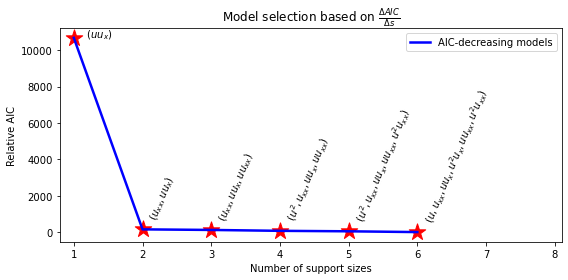

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(complexities, relative_decreasing_aics, color='blue', linewidth=2.5, label="AIC-decreasing models")
ax.scatter(complexities, relative_decreasing_aics, marker='*', c='red', s=300)
for com, name, rel_aic in zip(complexities, eff_feature_names, relative_decreasing_aics):
    rotation = (90+45)/2
    if com == 1: rotation = 0
    ax.annotate(f"    $({','.join(name)})$", (com, rel_aic), rotation=rotation)
plt.xlim(0.8,8.1)
plt.title(r"Model selection based on $\frac{\Delta AIC}{\Delta s}$")
plt.ylabel("Relative AIC")
plt.xlabel("Number of support sizes")
plt.legend()
plt.tight_layout()
# plt.savefig(join_path(FIGURE_EXPORT_PATH, "aic_model_selection.png"), dpi=300)
plt.show()

In [24]:
good_coms = set()
min_pok = 0.01
max_pok = 1.
delta_pok = min_pok
for p in np.arange(min_pok, max_pok+delta_pok, delta_pok):
    c = find_transition_V5(decreasing_aics, complexities, percent_ok=p)
    good_coms.add(c)
good_coms

2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve: 0.1652447290393721
4 does not improve 2
Percent improve: 0.000544265224371957
2 improves 1
Percent improve

{1, 2}

In [25]:
### RDAE ###
# -12389.963195450575

### ksvd ###
# no filter
# n_comp = 8 -> -9047.553796278982
# n_comp = 16 -> -9765.622573120214
# n_comp = 32 -> -10536.38751942126
# n_comp = 64 -> -10352.02875804546

# lowess transform_n_nonzero_coefs_none
# n_comp = 8 -> -24401.9389418036
# n_comp = 16 -> -24691.76627305709
# n_comp = 32 -> -24959.709959679923
# n_comp = 64 -> -24764.429429510492

# kalman transform_n_nonzero_coefs_none
# n_comp = 8 -> -24885.56632890232
# n_comp = 16 -> -25232.98595637962
# n_comp = 32 -> -25588.41567926969
# n_comp = 64 -> -25426.439846555484
# kalman transform_n_nonzero_coefs1
# n_comp = 8 -> -25891.828620483968
# n_comp = 16 -> -25971.78585120196
# n_comp = 32 -> -25934.634833973236
# n_comp = 64 -> -26581.895008216423

# gaussian transform_n_nonzero_coefs_none
# n_comp = 8 -> -25196.800131085605
# n_comp = 16 -> -25431.84926941515
# n_comp = 32 -> -25916.951667960224
# n_comp = 64 -> -25736.902542940414
# gaussian transform_n_nonzero_coefs1
# n_comp = 8 -> -26469.26580282442
# n_comp = 16 -> -26869.639789218723
# n_comp = 32 -> -26454.30774999768
# n_comp = 64 -> -26941.29946099699

### dictionary learning (increase n_comp until the diff in AIC/BIC drops) ###
### only with transform_n_nonzero_coefs_none
### aic ###
# lowess
# n_comp = 8 -> -20140.686246364276
# n_comp = 16 -> -20648.56772998038
# n_comp = 32 -> -20432.913180842457
# n_comp = 64 -> -21502.00430136999
# kalman
# n_comp = 8 -> -23844.3589917847
# n_comp = 16 -> -24251.69743649113
# n_comp = 32 -> -24075.305724278223
# n_comp = 64 -> -24346.695904317035

# gaussian

print(smoother_name, n_components)
print(decreasing_aics[1]-decreasing_aics[0])
decreasing_aics, complexities, eff_feature_names

none 32
-10536.38751942126


(array([-63762.32138037, -74298.7088998 , -74330.81920716, -74379.58530674,
        -74405.34064758, -74448.66917638]),
 array([1, 2, 3, 4, 5, 6]),
 [['uu_{x}'],
  ['u_{xx}', 'uu_{x}'],
  ['u_{xx}', 'uu_{x}', 'uu_{xx}'],
  ['u^2', 'u_{xx}', 'uu_{x}', 'uu_{xx}'],
  ['u^2', 'u_{xx}', 'uu_{x}', 'uu_{xx}', 'u^2u_{xx}'],
  ['u', 'u_{xx}', 'uu_{x}', 'u^2u_{x}', 'uu_{xx}', 'u^2u_{xx}']])

#### More model selection

In [26]:
# Use PDE_FIND_Loss from parametric_pde_find.py by formulating as a parametric problem
# Moving horizon in time

def AIC_Loss(A,b,x,epsilon=1e-5):
    N = A.shape[0]
    k = np.count_nonzero(x)
    rss = ((b-A.dot(x))**2).sum()
    aic = N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
    return aic

def PDE_FIND_Loss(As,bs,x,cv=0,epsilon=1e-5,ic_type="bic"):
    D,m = x.shape
    n,_ = As[0].shape
    N = n*m
    rss = np.sum([np.linalg.norm(bs[j] - As[j].dot(x[:,j].reshape(D,1)))**2 for j in range(m)])  
    k = (np.count_nonzero(x)/m)*(1+cv)
    if ic_type == "aic":
        return N*np.log(rss/N+epsilon) + 2*k + (2*k**2+2*k)/(N-k-1)
    elif ic_type == "bic":
        return N*np.log(rss/N+epsilon) + np.log(N)*k

In [27]:
# n_ensemble_models = 50
# model = ps.SINDy(feature_library=diff_lib, optimizer=optimizer, 
#                  differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
#                  feature_names=['u'])
# model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
#           library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)

diff_lib = ps.PDELibrary(library_functions=library_functions, 
                         function_names=library_function_names, 
                         derivative_order=2, 
                         spatial_grid=x, 
                         is_uniform=True, 
                         differentiation_method=KalmanDiff, 
                         differentiation_kwargs=differentiation_kwargs)

candidate_lib = diff_lib.fit_transform(np.expand_dims(un[:, :], -1))
candidate_lib = candidate_lib.reshape(-1, candidate_lib.shape[-1])
dynamics = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                           axis=1)._differentiate(un[:, :], 
                                                                  t).reshape(-1,1)
m, n = len(x), len(t)

com2coeff = {}
for com in st.track.keys():
    indices, _ = st.track[com]
    coeff = np.zeros(shape=(candidate_lib.shape[-1], 1))
    coeff[list(indices)] = np.linalg.lstsq(candidate_lib[:, indices], dynamics)[0]
    coeff = np.hstack([coeff for _ in range(n)])
    com2coeff[com] = coeff

In [28]:
Theta_grouped = [candidate_lib[j*n:(j+1)*n,:] for j in range(m)]
Ut_grouped = [dynamics[j*n:(j+1)*n] for j in range(m)]

# how about calculate coeff wrt to time var as well
PDE_Losses = []
for com in st.track.keys():
    PDE_Loss = PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2coeff[com])
    PDE_Losses.append(PDE_Loss)
PDE_Losses = np.array(PDE_Losses)
PDE_Losses

array([-67912.33446611, -69525.52741269, -70021.37516584, -70006.77648679,
       -69817.10860449, -70282.60535745, -70304.05660183, -70302.18125563])

In [29]:
maxi = np.max(t); mini = np.min(t)
mid = (mini+maxi)/2
ss = np.arange(0, len(t)-(list(t).index(mid)), dtype=np.int)

com2coeff_sub = {}
for s in ss:
    t_sub_indices = [i+s for i in range(list(t).index(mid)+1)]
    t_sub = t[t_sub_indices]
    un_sub = (un.copy())[:, t_sub_indices]
    print(t_sub_indices[0], "->", t_sub_indices[-1])

    diff_lib = ps.PDELibrary(library_functions=library_functions, 
                             function_names=library_function_names, 
                             derivative_order=2, 
                             spatial_grid=x, 
                             is_uniform=True, 
                             differentiation_method=KalmanDiff, 
                             differentiation_kwargs=differentiation_kwargs)

    candidate_lib_sub = diff_lib.fit_transform(np.expand_dims(un_sub, -1))
    candidate_lib_sub = candidate_lib_sub.reshape(-1, candidate_lib_sub.shape[-1])
    dynamics_sub = diff_lib.differentiation_method(**diff_lib.differentiation_kwargs, 
                                                   axis=1)._differentiate(un_sub, 
                                                                          t_sub).reshape(-1,1)
    
    m, n = len(x), len(t_sub)
    Theta_grouped_sub = [candidate_lib_sub[j*n:(j+1)*n,:] for j in range(m)]
    Ut_grouped_sub = [dynamics_sub[j*n:(j+1)*n] for j in range(m)]
    
    for com in st.track.keys():
        indices, _ = st.track[com]
        
        coeff = np.hstack([np.linalg.lstsq(Theta_grouped_sub[_][:, indices], 
                                           Ut_grouped_sub[_], 
                                           rcond=None)[0] for _ in range(n)])
        
#         coeff = np.zeros(shape=(candidate_lib_sub.shape[-1], 1))
#         coeff[list(indices)] = np.linalg.lstsq(candidate_lib_sub[:, indices], dynamics_sub)[0]
#         coeff = np.hstack([coeff for _ in range(n)])
    
        coeff = np.expand_dims(coeff, 0)
        if com not in com2coeff_sub: 
            com2coeff_sub[com] = coeff
        else: 
            com2coeff_sub[com] = np.vstack((com2coeff_sub[com], coeff))

0 -> 50
1 -> 51
2 -> 52
3 -> 53
4 -> 54
5 -> 55
6 -> 56
7 -> 57
8 -> 58
9 -> 59
10 -> 60
11 -> 61
12 -> 62
13 -> 63
14 -> 64
15 -> 65
16 -> 66
17 -> 67
18 -> 68
19 -> 69
20 -> 70
21 -> 71
22 -> 72
23 -> 73
24 -> 74
25 -> 75
26 -> 76
27 -> 77
28 -> 78
29 -> 79
30 -> 80
31 -> 81
32 -> 82
33 -> 83
34 -> 84
35 -> 85
36 -> 86
37 -> 87
38 -> 88
39 -> 89
40 -> 90
41 -> 91
42 -> 92
43 -> 93
44 -> 94
45 -> 95
46 -> 96
47 -> 97
48 -> 98
49 -> 99
50 -> 100


In [30]:
cvs = np.zeros((len(st.track.keys()), len(diff_lib.get_feature_names())))
for com in st.track.keys():
    indices, _ = st.track[com]
    cv_com = np.zeros(len(diff_lib.get_feature_names()))
    ### treat a seq of coeff values in one horizon as a mean constant number ###
    # mh_coeffs = np.mean(com2coeff_sub[com], axis=-1)
    # cv_com[list(indices)] = np.abs(np.std(mh_coeffs, axis=0)/np.mean(mh_coeffs, axis=0))
    cv_com[list(indices)] = np.abs(com2coeff_sub[com].std(axis=0)/com2coeff_sub[com].mean(axis=0)).mean(axis=-1)
    cvs[com-1] = cv_com
cvs

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  3.16716919,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  5.48933162,  5.58056449,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.66511713, 10.7763951 ,
         0.        ,  5.35752902,  0.        ],
       [ 0.        ,  5.7949652 ,  0.        ,  3.6186125 ,  5.04595557,
         0.        ,  3.7002179 ,  0.        ],
       [ 0.        ,  3.81283412,  0.        ,  5.32012283,  8.9548675 ,
         0.        ,  3.58646322,  5.90513308],
       [ 3.53348098,  0.        ,  0.        , 18.95569615,  4.53690324,
         4.89314907,  5.24903873,  5.17690473],
       [45.80213691,  4.60757453,  0.        ,  4.31612437,  3.37140872,
         5.20547556, 12.97400718,  5.80361758],
       [ 4.38632671,  7.0125313 ,  5.6127036 ,  5.3912857 ,  6.91203321,
         6.03198753,  2.79888429,  3.24593969]])

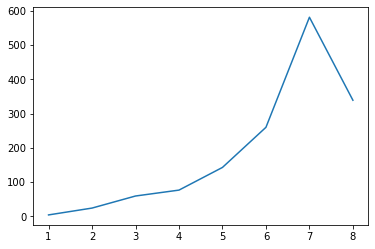

In [31]:
plt.plot([i for i in range(1,9)], np.array([i for i in range(1,9)])*(1+cvs.sum(axis=-1)))
plt.show()

In [32]:
maxp = 1000 # 10 for aic | 1000 for BIC
agg_PDE_Losses_cv = []
for p in range(1, maxp+1):
    PDE_Losses_cv = []
    for com in st.track.keys():
        PDE_Loss = PDE_FIND_Loss(Theta_grouped, Ut_grouped, com2coeff[com], 
                                 cv=p*cvs.sum(axis=-1)[com-1], ic_type='bic')
        PDE_Losses_cv.append(PDE_Loss)
    agg_PDE_Losses_cv.append(PDE_Losses_cv)
set(np.argmin(agg_PDE_Losses_cv, axis=-1))

{0, 1, 2}

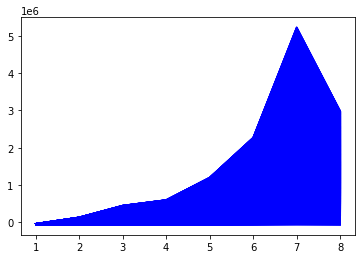

In [33]:
for i in range(len(agg_PDE_Losses_cv)):
    plt.plot([i for i in range(1,9)], agg_PDE_Losses_cv[i], c='blue')
plt.show()

In [34]:
raise SystemExit("Stop right here!")

SystemExit: Stop right here!

In [ ]:
X_pre = np.zeros(X_pre.shape)
y_pre = np.zeros(y_pre.shape)
n_times = 10
weak_coeffs = []
for _ in range(n_times):
    weak_pde_lib = ps.WeakPDELibrary(library_functions=[lambda x: x, lambda x: x * x], 
                                     function_names=[lambda x: x, lambda x: x + x], 
                                     derivative_order=diff_order, p=diff_order, 
                                     spatiotemporal_grid=XT, 
                                     include_bias=False, is_uniform=True, K=10000, 
                                     differentiation_method=differentiation_method, 
                                     differentiation_kwargs=differentiation_kwargs, 
                                     cache=True
                                    )
    kwargs = {'fit_intercept':False, 'copy_X':True, 'normalize_columns':False}
    # Apply moving horizon to un is an interesting idea.
    X_pre_sub, y_pre_sub, fns = ps_features(un, t, weak_pde_lib, kwargs)
    X_pre = X_pre + X_pre_sub
    y_pre = y_pre + y_pre_sub
    optimizer = L0BNB(max_nonzeros=2, lam=1e-3, is_normal=True, normalize_columns=False)
    n_ensemble_models = 50
    model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, 
                     differentiation_method=KalmanDiff(alpha=kalpha, poly_deg=poly_deg, rpca_lambda=rpca_lambda, axis=0, is_uniform=True), 
                     cache=True,
                     feature_names=['u'])
    model.fit(np.expand_dims(un, -1), t=dt, ensemble=True, 
              library_ensemble=True, n_candidates_to_drop=1, n_models=n_ensemble_models)
    ols_model, eff_rhs_indices = model.validate_coef_list()[0]
    print(np.array([convert2latex(f) for i,f in enumerate(model.get_feature_names()) if i in eff_rhs_indices]))
    print(ols_model.params)
    # percent_coeff = evaluate_coefficients(ols_model.params)
    # print(percent_coeff)
    # if percent_coeff[0] > 100: break
    weak_coeffs.append(ols_model.params)
weak_coeffs = np.array(weak_coeffs)
avg_weak_coeff = np.mean(weak_coeffs, axis=0)
X_pre = X_pre/n_times
y_pre = y_pre/n_times

In [ ]:
# RDAE 5e-0: cv = 0.005062929348375081, 0.011023507990422338
# RDAE 1e-0: cv = 0.004408008789094885, 0.00910193468516509
# RDAE 5e-1: cv = 0.003467511174737858, 0.008040505161991068
# RDAE 5e-2: cv = 0.004305311364345706, 0.007809099375818377

cv_abs = (weak_coeffs.std(axis=0)/np.abs(weak_coeffs.mean(axis=0))).mean()
cv = (weak_coeffs.std(axis=0)/weak_coeffs.mean(axis=0)).mean()
cv, cv_abs

In [ ]:
# 50 percent noise
# Robust PCA: (14.745720655392669, 6.347415766367691)
# RDAE failed...

# 40 percent noise
# Robust PCA: (14.818002368919029, 7.899799685479938)
# RDAE 5e-0: (2.9505659028666087, 1.8024006266427972)
# RDAE 1e-0: (3.2008235132427463, 2.56690175990938)
# RDAE 5e-1: (2.469185388081714, 1.7166311808760781)
# RDAE 5e-2: (6.015975755333656, 5.859365864415776)
# RDAE 5e-3: Failed

evaluate_coefficients(avg_weak_coeff)

In [ ]:
def percent_coeff(pred, ground):
    return 100*np.abs(pred-ground)/np.abs(ground)
print(avg_weak_coeff)
errs = percent_coeff(avg_weak_coeff, np.array([0.1, -1]))
errs.mean(), errs.std()

In [ ]:
print(np.linalg.lstsq(X_pre[:, [3,4]], y_pre, rcond=None)[0].flatten())
evaluate_coefficients(np.linalg.lstsq(X_pre[:, [3,4]], y_pre, rcond=None)[0].flatten())

In [ ]:
best_subsets = sorted([indices for _, (indices, _) in st.track.items()], key=lambda _: len(_))
tmp = np.zeros((len(best_subsets), X_pre.shape[-1]))
for i in range(len(best_subsets)):
    tmp[i:i+1, :][0, best_subsets[i]] = 1.0
best_subsets = tmp.astype(np.float32)
del tmp

pms_data = {nameof(un): un, 
            nameof(X_pre): X_pre, 
            nameof(y_pre): y_pre, 
            nameof(avg_weak_coeff): avg_weak_coeff, 
            nameof(best_subsets): best_subsets}
pms_data

In [ ]:
basic_vars = {'u'}
encoded_feature_names = []
for feature in model.get_feature_names():
    out_feature = []
    last_index = -1
    for i, c in enumerate(feature):
        if i+1 < len(feature) and feature[i+1] in basic_vars:
            last_index = i
            out_feature.append(c+'*')
    out_feature.append(feature[last_index+1:])
    encoded_feature_names.append(''.join(out_feature))
encoded_feature_names = np.array(encoded_feature_names)
encoded_feature_names.tolist()

In [ ]:
for com in sorted(st.track.keys()):
    indices, _ = st.track[com]
    expr = '+'.join(encoded_feature_names[list(indices)])
    print(expr)
    print('----------')
encoded_pde_names = ['+'.join(encoded_feature_names[list(indices)]) for _, (indices, _) 
                     in sorted(st.track.items())]

In [ ]:
import yaml
from omegaconf import OmegaConf
yml = {}
yml["encoded_feature_names"] = encoded_feature_names.tolist()
yml["encoded_pde_names"] = encoded_pde_names
yml["information_criterion_score"] = [float(ic) for _, (_, ic) in st.track.items()]

#### Save files for training PINNs & DeepONets

In [ ]:
fp1 = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_pms_noise30_dictlearn{n_components}.h5"
fp2 = f"../PMS_data/{denoising_mode}/{smoother_name}/transform_n_nonzero_coefs{transform_n_nonzero}/burgers_pms_feature_names_noise30_dictlearn{n_components}.yaml"
fp1, fp2

In [ ]:
h5file(file_path=fp1, cdict=pms_data, mode='w')
OmegaConf.save(config=OmegaConf.create(yml), f=fp2)
yml2 = OmegaConf.load(fp2)
X_pre_rev, avg_weak_coeff, best_subsets, un, y_pre_rev = h5file(file_path=fp1, mode='r', return_dict=False)

In [ ]:
print(np.linalg.lstsq(X_pre_rev[:, [3,4]], y_pre_rev, rcond=None)[0].flatten())
evaluate_coefficients(np.linalg.lstsq(X_pre_rev[:, [3,4]], y_pre_rev, rcond=None)[0].flatten())

#### Physics-informed model selection.... (2 options)
    - Fixed coefficients + learned diffivative values (by autodiff)
    - Fixed polynomial candidate values (following feature_names: ['u', 'uu', 'u_1', 'u_11', 'uu_1', 'uuu_1', 'uu_11', 'uuu_11']) + learned coefficients